In [50]:
import os
import warnings
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from numpy import exp
from scipy import ndimage
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def relu(Z):
    return np.maximum(0,Z)

In [4]:
def sigmoid(Z):
    return 1/(1+exp(-Z))

In [5]:
with open('my_dataset.pickle', 'rb') as data:
    dataset = pickle.load(data)

In [6]:
X_train=dataset['X_train']
Y_train=dataset['Y_train']
print(X_train.shape,Y_train.shape)

(49152, 1992) (1, 1992)


In [7]:
def initialize_parameters(layer_dims):
    """
    Arguements:
    layer_dims -- python list containing number of nodes in each layer
    
    Returns:
    parameters -- python dictionary containing randomly initializes W and zeros b
    """
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        #parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.5
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [8]:
def linear_activation_forward(A_prev,W,b,activation):
    Z=np.dot(W,A_prev)+b
 
    if activation=='relu':
        A=relu(Z)
    elif activation=='sigmoid':
        A=sigmoid(Z)
    linear_cache = (A_prev,W,b)
    activation_cache = (Z) 
    cache = (linear_cache,activation_cache)
    
    return A,cache

In [9]:
def forward_propagate(X,parameters):
    L = len(parameters) // 2 
    u_cache=[]
    A = X
    for l in range(1,L):
        A_prev = A
        A,cache = linear_activation_forward(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],'relu')
        u_cache.append(cache)
    A_prev=A
    A,cache=linear_activation_forward(A_prev,parameters['W'+str(L)],parameters['b'+str(L)],'sigmoid')
    u_cache.append(cache)
    
    assert(A.shape == (1,X.shape[1]))
    
    return A,u_cache

In [10]:
def compute_cost(Y_hat,Y,L,parameters,lambd):
    m=Y.shape[1]
    sq_cost= 0
    
    if lambd is not 0:
        for i in range(1,L+1):
            t = parameters['W'+str(i)]
            sq_cost += np.sum(np.sum(t*t))
    
    cost=(-1/m)*np.sum(Y*np.log(Y_hat)+(1-Y)*np.log(1-Y_hat)) + (lambd/(2*m))*sq_cost
    cost=np.squeeze(cost)
    assert(cost.shape == ())
    return cost

In [11]:
def der_sigmoid(Z):
    return sigmoid(Z)*(1-sigmoid(Z))

In [12]:
def der_relu(Z):
    return (Z>0).astype(int)

In [13]:
print(der_relu(np.array([0.5])))

[1]


In [14]:
def linear_activation_backward(dA,activation,current_cache,lambd=0):
    A_prev , W , b = current_cache[0]
    Z = current_cache[1]
    m = A_prev.shape[1]
    if activation == 'sigmoid':
        s = sigmoid(Z)
        dZ = dA*s*(1-s)
    elif activation == 'relu':
        dZ = np.array(dA,copy=True)
        dZ[Z<=0] = 0
    
    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev , dW , db

In [20]:
def backward_propagation(Y,AL,caches,lambd):
    
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL,"sigmoid",current_cache,lambd)
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], "relu",current_cache, lambd)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [16]:
def update_parameters(parameters, learning_rate ,grads):
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [38]:
def accuracy(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = forward_propagate(X, parameters)
    count1=count0 = 0
    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
            count1 += 1
        else:
            p[0,i] = 0
            count0 += 1
    
    print('Count 1 = ' + str(count1))
    print('Count 0 = ' + str(count0))
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [45]:
def predict(X,parameters):
    Y,_ = forward_propagate(X,parameters)
    Y = np.squeeze(Y)
    if Y>0.5:
        print("It's a dog")
    else:
        print("It's a cat")

In [30]:
def model(parameters,X_train,Y_train,epochs,layer_dims,print_cost=True,learning_rate = 0.0075,lambd=0):
    costs = []
    #parameters=initialize_parameters(layer_dims)
    L = len(parameters) // 2
    for i in range(epochs):
        Y_hat , u_cache = forward_propagate(X_train,parameters)
        cost= compute_cost(Y_hat,Y_train,L,parameters,lambd)
        if print_cost == True and i%100 ==0 :
            print('Cost after iteration '+ str(i) + '= ' + str(cost))
            costs.append(cost)
        u_grads = backward_propagation(Y_train,Y_hat,u_cache,lambd)
        parameters = update_parameters(parameters, learning_rate ,u_grads)
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return parameters

Cost after iteration 0= 0.3271934380835127
Cost after iteration 100= 0.33272153310509806
Cost after iteration 200= 0.5866289123210973
Cost after iteration 300= 0.26919179504866275
Cost after iteration 400= 0.42686172720161797
Cost after iteration 500= 0.3124112691228945
Cost after iteration 600= 0.256802582239492
Cost after iteration 700= 0.17794274904531363
Cost after iteration 800= 0.1663147821308893
Cost after iteration 900= 0.23311316173049604
Cost after iteration 1000= 0.17544738931066786
Cost after iteration 1100= 0.11727584552484686
Cost after iteration 1200= 0.07201497029841648


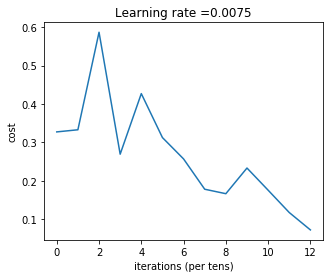

"\nThis section contains the parameters which we have obtained after the training the model \nUncomment this section to use the pretrained parameters for predicting and to save time unless u want to train a new model\nwith modifications!\nwith open('parameters.pickle', 'rb') as data:\n    parameters = pickle.load(data)\n"

In [32]:
layer_dims=[X_train.shape[0],200,100,50,Y_train.shape[0]]
parameters = initialize_parameters(layer_dims) #comment out this line if u are using pretrained parameters below
"""
This section contains the parameters which we have obtained after the training the model 
Uncomment this section to use the pretrained parameters for predicting and to save time unless u want to train a new model
with modifications!
with open('parameters.pickle', 'rb') as data:
    parameters = pickle.load(data)
"""
parameters = model (parameters,X_train , Y_train , 1300 , layer_dims, lambd=0 )

In [39]:
accuracy(X_train , Y_train , parameters)

Count 1 = 1006
Count 0 = 986
Accuracy: 0.9959839357429721


array([[0., 1., 0., ..., 1., 1., 0.]])

In [35]:
# run this cell only if u find accuracy better than 99.5%
with open('parameters.pickle', 'wb') as output:
    pickle.dump(parameters, output)

It's a dog


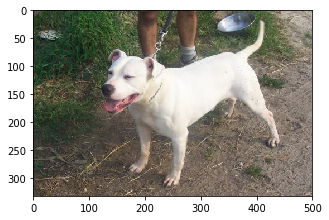

In [56]:
# Test any image
image = "test.jpg"

#preprocess the image
num_px = np.int32(128)
img_test = mpimg.imread(image)
plt.imshow(img_test)
img_test = scipy.misc.imresize(img_test, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
img_test = img_test / 255
predict(img_test,parameters)